# House Price Prediction

The goal of this project is to predict the sales price of residential homes in Ames, Iowa, USA based on various of attributes. It is a supervised regression problem.

# Import Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from scipy import stats
from scipy.stats import norm, shapiro, anderson, kstest, normaltest

# 1. Load the Data

In [3]:
train = pd.read_csv("data/train.csv", header=0)
test = pd.read_csv("data/test.csv", header=0)

# 2. Understand the Data

In [4]:
print("Train: ",train.shape[0],"rows and ",train.shape[1],"features")
print("Test: ",test.shape[0],"rows and ",test.shape[1],"features")

Train:  1460 rows and  81 features
Test:  1459 rows and  80 features


In [5]:
display(train.head(5))
display(test.head(5))

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

There is a mix of qualitative (categorical) and quatitative (numerical) features.

There is a mismatch in datatype between the train and test data set. Let's fix that.

In [8]:
# Create a comparison DataFrame
dtype_comparison = pd.DataFrame({
    'train_dtype': train.dtypes,
    'test_dtype': test.dtypes
})

# Add a column to check if they match
dtype_comparison['match'] = dtype_comparison['train_dtype'] == dtype_comparison['test_dtype']

# Filter where there is a mismatch
dtype_comparison = dtype_comparison[dtype_comparison['match'] == False]

In [9]:
dtype_comparison

train_dtype test_dtype  match
BsmtFinSF1         int64    float64  False
BsmtFinSF2         int64    float64  False
BsmtFullBath       int64    float64  False
BsmtHalfBath       int64    float64  False
BsmtUnfSF          int64    float64  False
GarageArea         int64    float64  False
GarageCars         int64    float64  False
SalePrice          int64        NaN  False
TotalBsmtSF        int64    float64  False

Based on the feature description provided:
- BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, GarageArea, TotalBsmtSF are floats.
- BsmtFullBath, BsmtHalfBath, GarageCars are int.

In [10]:
train[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageArea', 'TotalBsmtSF']] = train[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageArea', 'TotalBsmtSF']].astype('float64')
test[['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']] = test[['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']].fillna(0).astype('int64')

Let's create a list of quantitative and qualitative columns.

In [11]:
quantitative = [
    'LotFrontage', 
    'LotArea', 
    'YearBuilt', 
    'YearRemodAdd', 
    'MasVnrArea', 
    'BsmtFinSF1', 
    'BsmtFinSF2', 
    'BsmtUnfSF', 
    'TotalBsmtSF', 
    '1stFlrSF', 
    '2ndFlrSF', 
    'LowQualFinSF', 
    'GrLivArea', 
    'GarageYrBlt', 
    'GarageArea', 
    'WoodDeckSF', 
    'OpenPorchSF', 
    'EnclosedPorch', 
    '3SsnPorch', 
    'ScreenPorch', 
    'PoolArea', 
    'MiscVal']

In [12]:
qualitative = [
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'MSSubClass',
 'OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'MoSold',
 'YrSold']

In [13]:
print(f"\nQuantitative features ({len(quantitative)}): {quantitative}")
print(f"Qualitative features ({len(qualitative)}): {qualitative}")
print(f"Total features: {len(quantitative) + len(qualitative)}")


Quantitative features (22): ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
Qualitative features (57): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath',

- total number of features: 79
- number of qualitative / categorical features : 57
- number of quantitative / numerical features : 22
- target variable : SalePrice
- row ID : Id

In [14]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [15]:
test.describe()

Id   MSSubClass  LotFrontage       LotArea  OverallQual  \
count  1459.000000  1459.000000  1232.000000   1459.000000  1459.000000   
mean   2190.000000    57.378341    68.580357   9819.161069     6.078821   
std     421.321334    42.746880    22.376841   4955.517327     1.436812   
min    1461.000000    20.000000    21.000000   1470.000000     1.000000   
25%    1825.500000    20.000000    58.000000   7391.000000     5.000000   
50%    2190.000000    50.000000    67.000000   9399.000000     6.000000   
75%    2554.500000    70.000000    80.000000  11517.500000     7.000000   
max    2919.000000   190.000000   200.000000  56600.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1459.000000  1459.000000   1459.000000  1444.000000  1458.000000  ...   
mean      5.553804  1971.357779   1983.662783   100.709141   439.203704  ...   
std       1.113740    30.390071     21.130467   177.625900   455.268042  ...   
min       1.000000  1879.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1953.000000   1963.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1992.000000     0.000000   350.500000  ...   
75%       6.000000  2001.000000   2004.000000   164.000000   753.500000  ...   
max       9.000000  2010.000000   2010.000000  1290.000000  4010.000000  ...   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  1458.000000  1459.000000  1459.000000    1459.000000  1459.000000   
mean    472.768861    93.174777    48.313914      24.243317     1.794380   
std     217.048611   127.744882    68.883364      67.227765    20.207842   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     318.000000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    28.000000       0.000000     0.000000   
75%     576.000000   168.000000    72.000000       0.000000     0.000000   
max    1488.000000  1424.000000   742.000000    1012.000000   360.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  
count  1459.000000  1459.000000   1459.000000  1459.000000  1459.000000  
mean     17.064428     1.744345     58.167923     6.104181  2007.769705  
std      56.609763    30.491646    630.806978     2.722432     1.301740  
min       0.000000     0.000000      0.000000     1.000000  2006.000000  
25%       0.000000     0.000000      0.000000     4.000000  2007.000000  
50%       0.000000     0.000000      0.000000     6.000000  2008.000000  
75%       0.000000     0.000000      0.000000     8.000000  2009.000000  
max     576.000000   800.000000  17000.000000    12.000000  2010.000000  

[8 rows x 37 columns]

In [16]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The house prices range from 34.9k to 755k with a mean of 180.9k.

# 3. Data Cleaning

## 3.1. Check for duplicates

In [17]:
train.duplicated().any()

np.False_

In [18]:
test.duplicated().any()

np.False_

## 3.2. Check for missing data
Let's check for 0, blank, NaN or None values.

In [19]:
def print_missing_values(df):
    """ 
    calculate the 0, blank, NaN or None values in df, in count and %
    filter rows where not all values are 0
    """

    missing_df = pd.concat([
        # Counts
        (df == 0).sum().rename('zeros_count'),
        (df == '').sum().rename('blanks_count'), 
        df.isna().sum().rename('nan_count'),
        (df == None).sum().rename('none_count'),
        
        # Percentages
        ((df == 0).sum() / len(df) * 100).round(1).rename('zeros_%'),
        ((df == '').sum() / len(df) * 100).round(1).rename('blanks_%'), 
        (df.isna().sum() / len(df) * 100).round(1).rename('nan_%'),
        ((df == None).sum() / len(df) * 100).round(1).rename('none_%')
    ], axis=1)

    # Filter rows where not all values are zero
    missing_df = missing_df[(missing_df.select_dtypes(include=[np.number]) != 0).any(axis=1)]

    # Sort by zeros count (descending) and then by NaN count (descending)
    missing_df = missing_df.sort_values(['zeros_count', 'nan_count'], ascending=[False, False])

    display(missing_df)

In [20]:
print_missing_values(train)

zeros_count  blanks_count  nan_count  none_count  zeros_%  \
PoolArea              1453             0          0           0     99.5   
3SsnPorch             1436             0          0           0     98.4   
LowQualFinSF          1434             0          0           0     98.2   
MiscVal               1408             0          0           0     96.4   
BsmtHalfBath          1378             0          0           0     94.4   
ScreenPorch           1344             0          0           0     92.1   
BsmtFinSF2            1293             0          0           0     88.6   
EnclosedPorch         1252             0          0           0     85.8   
HalfBath               913             0          0           0     62.5   
MasVnrArea             861             0          8           0     59.0   
BsmtFullBath           856             0          0           0     58.6   
2ndFlrSF               829             0          0           0     56.8   
WoodDeckSF             761             0          0           0     52.1   
Fireplaces             690             0          0           0     47.3   
OpenPorchSF            656             0          0           0     44.9   
BsmtFinSF1             467             0          0           0     32.0   
BsmtUnfSF              118             0          0           0      8.1   
GarageCars              81             0          0           0      5.5   
GarageArea              81             0          0           0      5.5   
TotalBsmtSF             37             0          0           0      2.5   
FullBath                 9             0          0           0      0.6   
BedroomAbvGr             6             0          0           0      0.4   
KitchenAbvGr             1             0          0           0      0.1   
PoolQC                   0             0       1453           0      0.0   
MiscFeature              0             0       1406           0      0.0   
Alley                    0             0       1369           0      0.0   
Fence                    0             0       1179           0      0.0   
MasVnrType               0             0        872           0      0.0   
FireplaceQu              0             0        690           0      0.0   
LotFrontage              0             0        259           0      0.0   
GarageType               0             0         81           0      0.0   
GarageYrBlt              0             0         81           0      0.0   
GarageFinish             0             0         81           0      0.0   
GarageQual               0             0         81           0      0.0   
GarageCond               0             0         81           0      0.0   
BsmtExposure             0             0         38           0      0.0   
BsmtFinType2             0             0         38           0      0.0   
BsmtQual                 0             0         37           0      0.0   
BsmtCond                 0             0         37           0      0.0   
BsmtFinType1             0             0         37           0      0.0   
Electrical               0             0          1           0      0.0   

               blanks_%  nan_%  none_%  
PoolArea            0.0    0.0     0.0  
3SsnPorch           0.0    0.0     0.0  
LowQualFinSF        0.0    0.0     0.0  
MiscVal             0.0    0.0     0.0  
BsmtHalfBath        0.0    0.0     0.0  
ScreenPorch         0.0    0.0     0.0  
BsmtFinSF2          0.0    0.0     0.0  
EnclosedPorch       0.0    0.0     0.0  
HalfBath            0.0    0.0     0.0  
MasVnrArea          0.0    0.5     0.0  
BsmtFullBath        0.0    0.0     0.0  
2ndFlrSF            0.0    0.0     0.0  
WoodDeckSF          0.0    0.0     0.0  
Fireplaces          0.0    0.0     0.0  
OpenPorchSF         0.0    0.0     0.0  
BsmtFinSF1          0.0    0.0     0.0  
BsmtUnfSF           0.0    0.0     0.0  
GarageCars          0.0    0.0     0.0  
GarageArea          0.0    0.0     0.0  
To

In [21]:
print_missing_values(test)

zeros_count  blanks_count  nan_count  none_count  zeros_%  \
PoolArea              1453             0          0           0     99.6   
3SsnPorch             1446             0          0           0     99.1   
LowQualFinSF          1445             0          0           0     99.0   
MiscVal               1408             0          0           0     96.5   
BsmtHalfBath          1366             0          0           0     93.6   
ScreenPorch           1319             0          0           0     90.4   
BsmtFinSF2            1278             0          1           0     87.6   
EnclosedPorch         1208             0          0           0     82.8   
HalfBath               921             0          0           0     63.1   
MasVnrArea             877             0         15           0     60.1   
BsmtFullBath           851             0          0           0     58.3   
2ndFlrSF               839             0          0           0     57.5   
WoodDeckSF             762             0          0           0     52.2   
Fireplaces             730             0          0           0     50.0   
OpenPorchSF            642             0          0           0     44.0   
BsmtFinSF1             462             0          1           0     31.7   
BsmtUnfSF              123             0          1           0      8.4   
GarageCars              77             0          0           0      5.3   
GarageArea              76             0          1           0      5.2   
TotalBsmtSF             41             0          1           0      2.8   
FullBath                 3             0          0           0      0.2   
BedroomAbvGr             2             0          0           0      0.1   
KitchenAbvGr             2             0          0           0      0.1   
PoolQC                   0             0       1456           0      0.0   
MiscFeature              0             0       1408           0      0.0   
Alley                    0             0       1352           0      0.0   
Fence                    0             0       1169           0      0.0   
MasVnrType               0             0        894           0      0.0   
FireplaceQu              0             0        730           0      0.0   
LotFrontage              0             0        227           0      0.0   
GarageYrBlt              0             0         78           0      0.0   
GarageFinish             0             0         78           0      0.0   
GarageQual               0             0         78           0      0.0   
GarageCond               0             0         78           0      0.0   
GarageType               0             0         76           0      0.0   
BsmtCond                 0             0         45           0      0.0   
BsmtQual                 0             0         44           0      0.0   
BsmtExposure             0             0         44           0      0.0   
BsmtFinType1             0             0         42           0      0.0   
BsmtFinType2             0             0         42           0      0.0   
MSZoning                 0             0          4           0      0.0   
Utilities                0             0          2           0      0.0   
Functional               0             0          2           0      0.0   
Exterior1st              0             0          1           0      0.0   
Exterior2nd              0             0          1           0      0.0   
KitchenQual              0             0          1           0      0.0   
SaleType                 0             0          1           0      0.0   

               blanks_%  nan_%  none_%  
PoolArea            0.0    0.0     0.0  
3SsnPorch           0.0    0.0     0.0  
LowQualFinSF        0.0    0.0     0.0  
MiscVal             0.0    0.0     0.0  
BsmtHalfBath        0.0    0.0     0.0  
ScreenPorch         0.0    0.0     0.0  
BsmtFinSF2          0.0    0.1     0.0  
EnclosedPorch       0.0    0.0     0.0

Some features have a lot of missing data (zeros and NaNs). Most of times NA means lack of subject described by attribute, like missing pool, fence, no garage and basement.

# 4. Exploratory Data Analysis

## 4.1. Univariate analysis

For each categorical variable, display the bar plot.

For each numerical variable, show histograms, measures of central tendency (mean, median, mode), and measures of dispersion (range, standard deviation, skewness, kurtosis). 

In [22]:
def plot_univariate(df, col, ax=None):
    """ plot histogram of column col on specified axes """
    if ax is None:
        ax = plt.gca()
    
    if col in qualitative:
        # for categorical variables
        sns.countplot(x=col, data=df, ax=ax)
    else:
        # for numerical variables
        sns.histplot(df[col], kde=True, ax=ax)

    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel(col)

In [23]:
def plot_univariate(df, col, ax=None, color='#1f77b4', alpha=1.0, label=None, is_shaded=False):
    """ plot histogram of column col on specified axes with customizable color and transparency """
    if ax is None:
        ax = plt.gca()
    
    if col in qualitative:
        # For categorical variables - handle both solid and shaded properly
        value_counts = df[col].value_counts().sort_index()
        x_pos = np.arange(len(value_counts))
        
        if is_shaded:
            # Shaded version for categorical
            ax.bar(x_pos, value_counts.values, alpha=alpha, color=color, 
                   label=label, edgecolor='none', width=0.8)
        else:
            # Solid version for categorical
            ax.bar(x_pos, value_counts.values, alpha=alpha, color=color, 
                   label=label, edgecolor='black', linewidth=1, width=0.6)
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels(value_counts.index.astype(str))
        
    else:
        # For numerical variables
        if is_shaded:
            sns.histplot(df[col], kde=True, ax=ax, color=color, alpha=alpha, 
                        label=label, fill=True, stat='density')
        else:            
            sns.histplot(df[col], kde=True, ax=ax, color=color, alpha=alpha, 
                        label=label, stat='density')

    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel(col)
    
    if label:
        ax.legend()

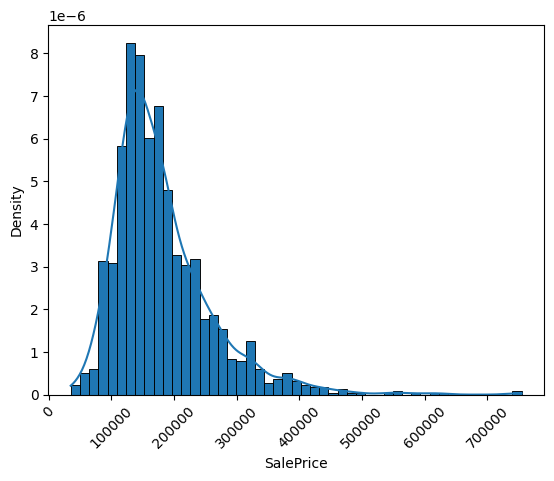

In [24]:
plot_univariate(train, 'SalePrice')

In [25]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


We notice that SalePrice :
- doesn't have a normal distribution
- has positive shewness
- has positive kurtosis (peakedness)

In [26]:
def plot_univariate_subplot(df, col_list):
    """
    Display a subplot of the univariate analysis for the columns in col_list 
    for dataframes df1 (train) and df2 (test)
    """
    if col_list == qualitative:
        fig, axes = plt.subplots(nrows=15, ncols=4, figsize=(20, 60))
    else:
        fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 30))
    
    # Flatten the 2D axes array for easier iteration
    axes_flat = axes.flatten()
    
    for i, ax in enumerate(axes_flat):
        if i < len(col_list):
            plot_univariate(df, col_list[i], ax=ax)
        else:
            # Hide unused subplots if you have fewer than 44 columns
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [27]:
def plot_univariate_subplot(df1, df2, col_list):
    """
    Display a subplot of the univariate analysis for the columns in col_list 
    for dataframes df1 (train) and df2 (test) with different colors and shading
    """
    if col_list == qualitative:
        fig, axes = plt.subplots(nrows=15, ncols=4, figsize=(20, 60))
    else:
        fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 30))
    
    # Define colors
    train_color = '#1f77b4'  # Blue
    test_color = '#ff7f0e'   # Orange
    
    axes_flat = axes.flatten()
    
    for i, ax in enumerate(axes_flat):
        if i < len(col_list):
            col = col_list[i]
            
            # Plot train data (solid, darker)
            plot_univariate(df1, col, ax=ax, color=train_color, alpha=0.8, 
                           label='Train', is_shaded=False)
            
            # Plot test data (shaded, lighter)
            plot_univariate(df2, col, ax=ax, color=test_color, alpha=0.6, 
                           label='Test', is_shaded=True)
            
            ax.legend()
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

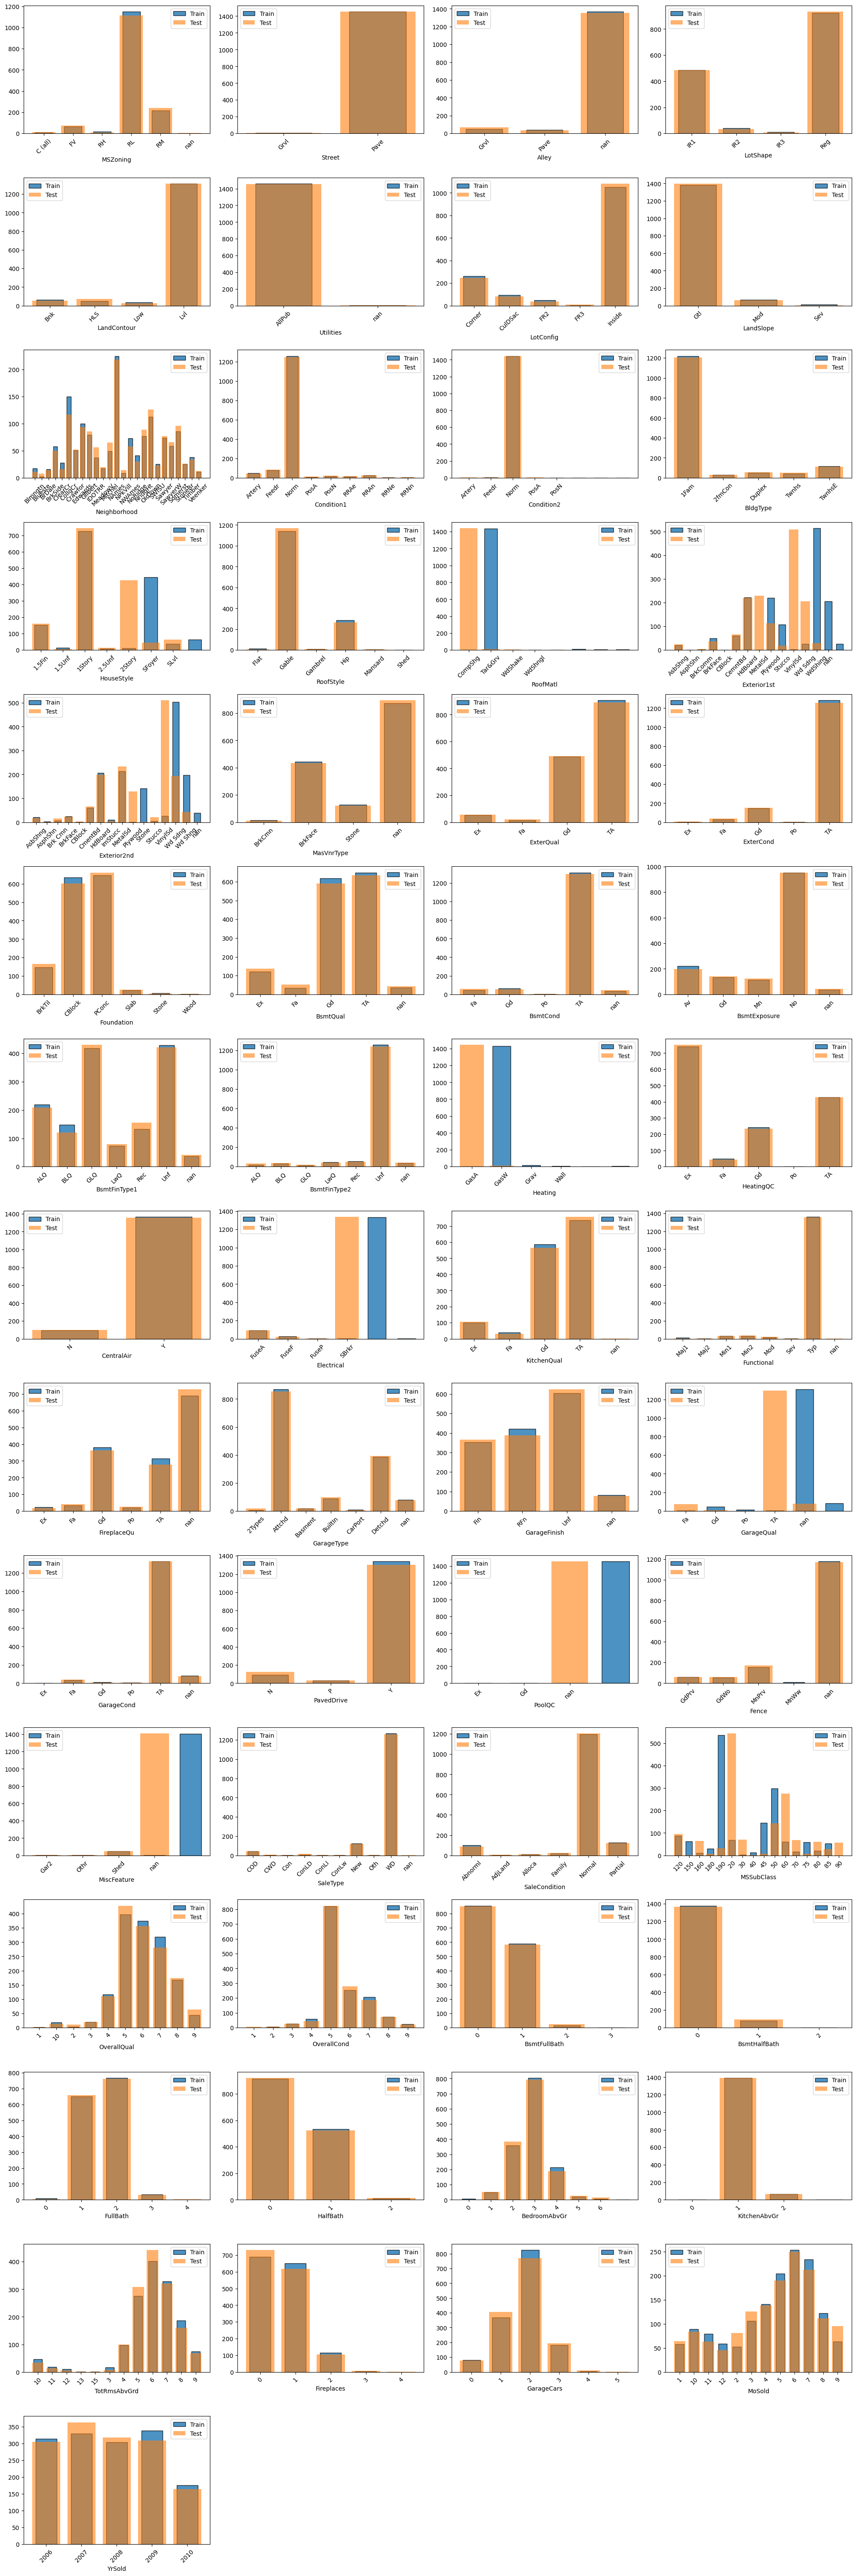

In [432]:
plot_univariate_subplot(train, test, qualitative)

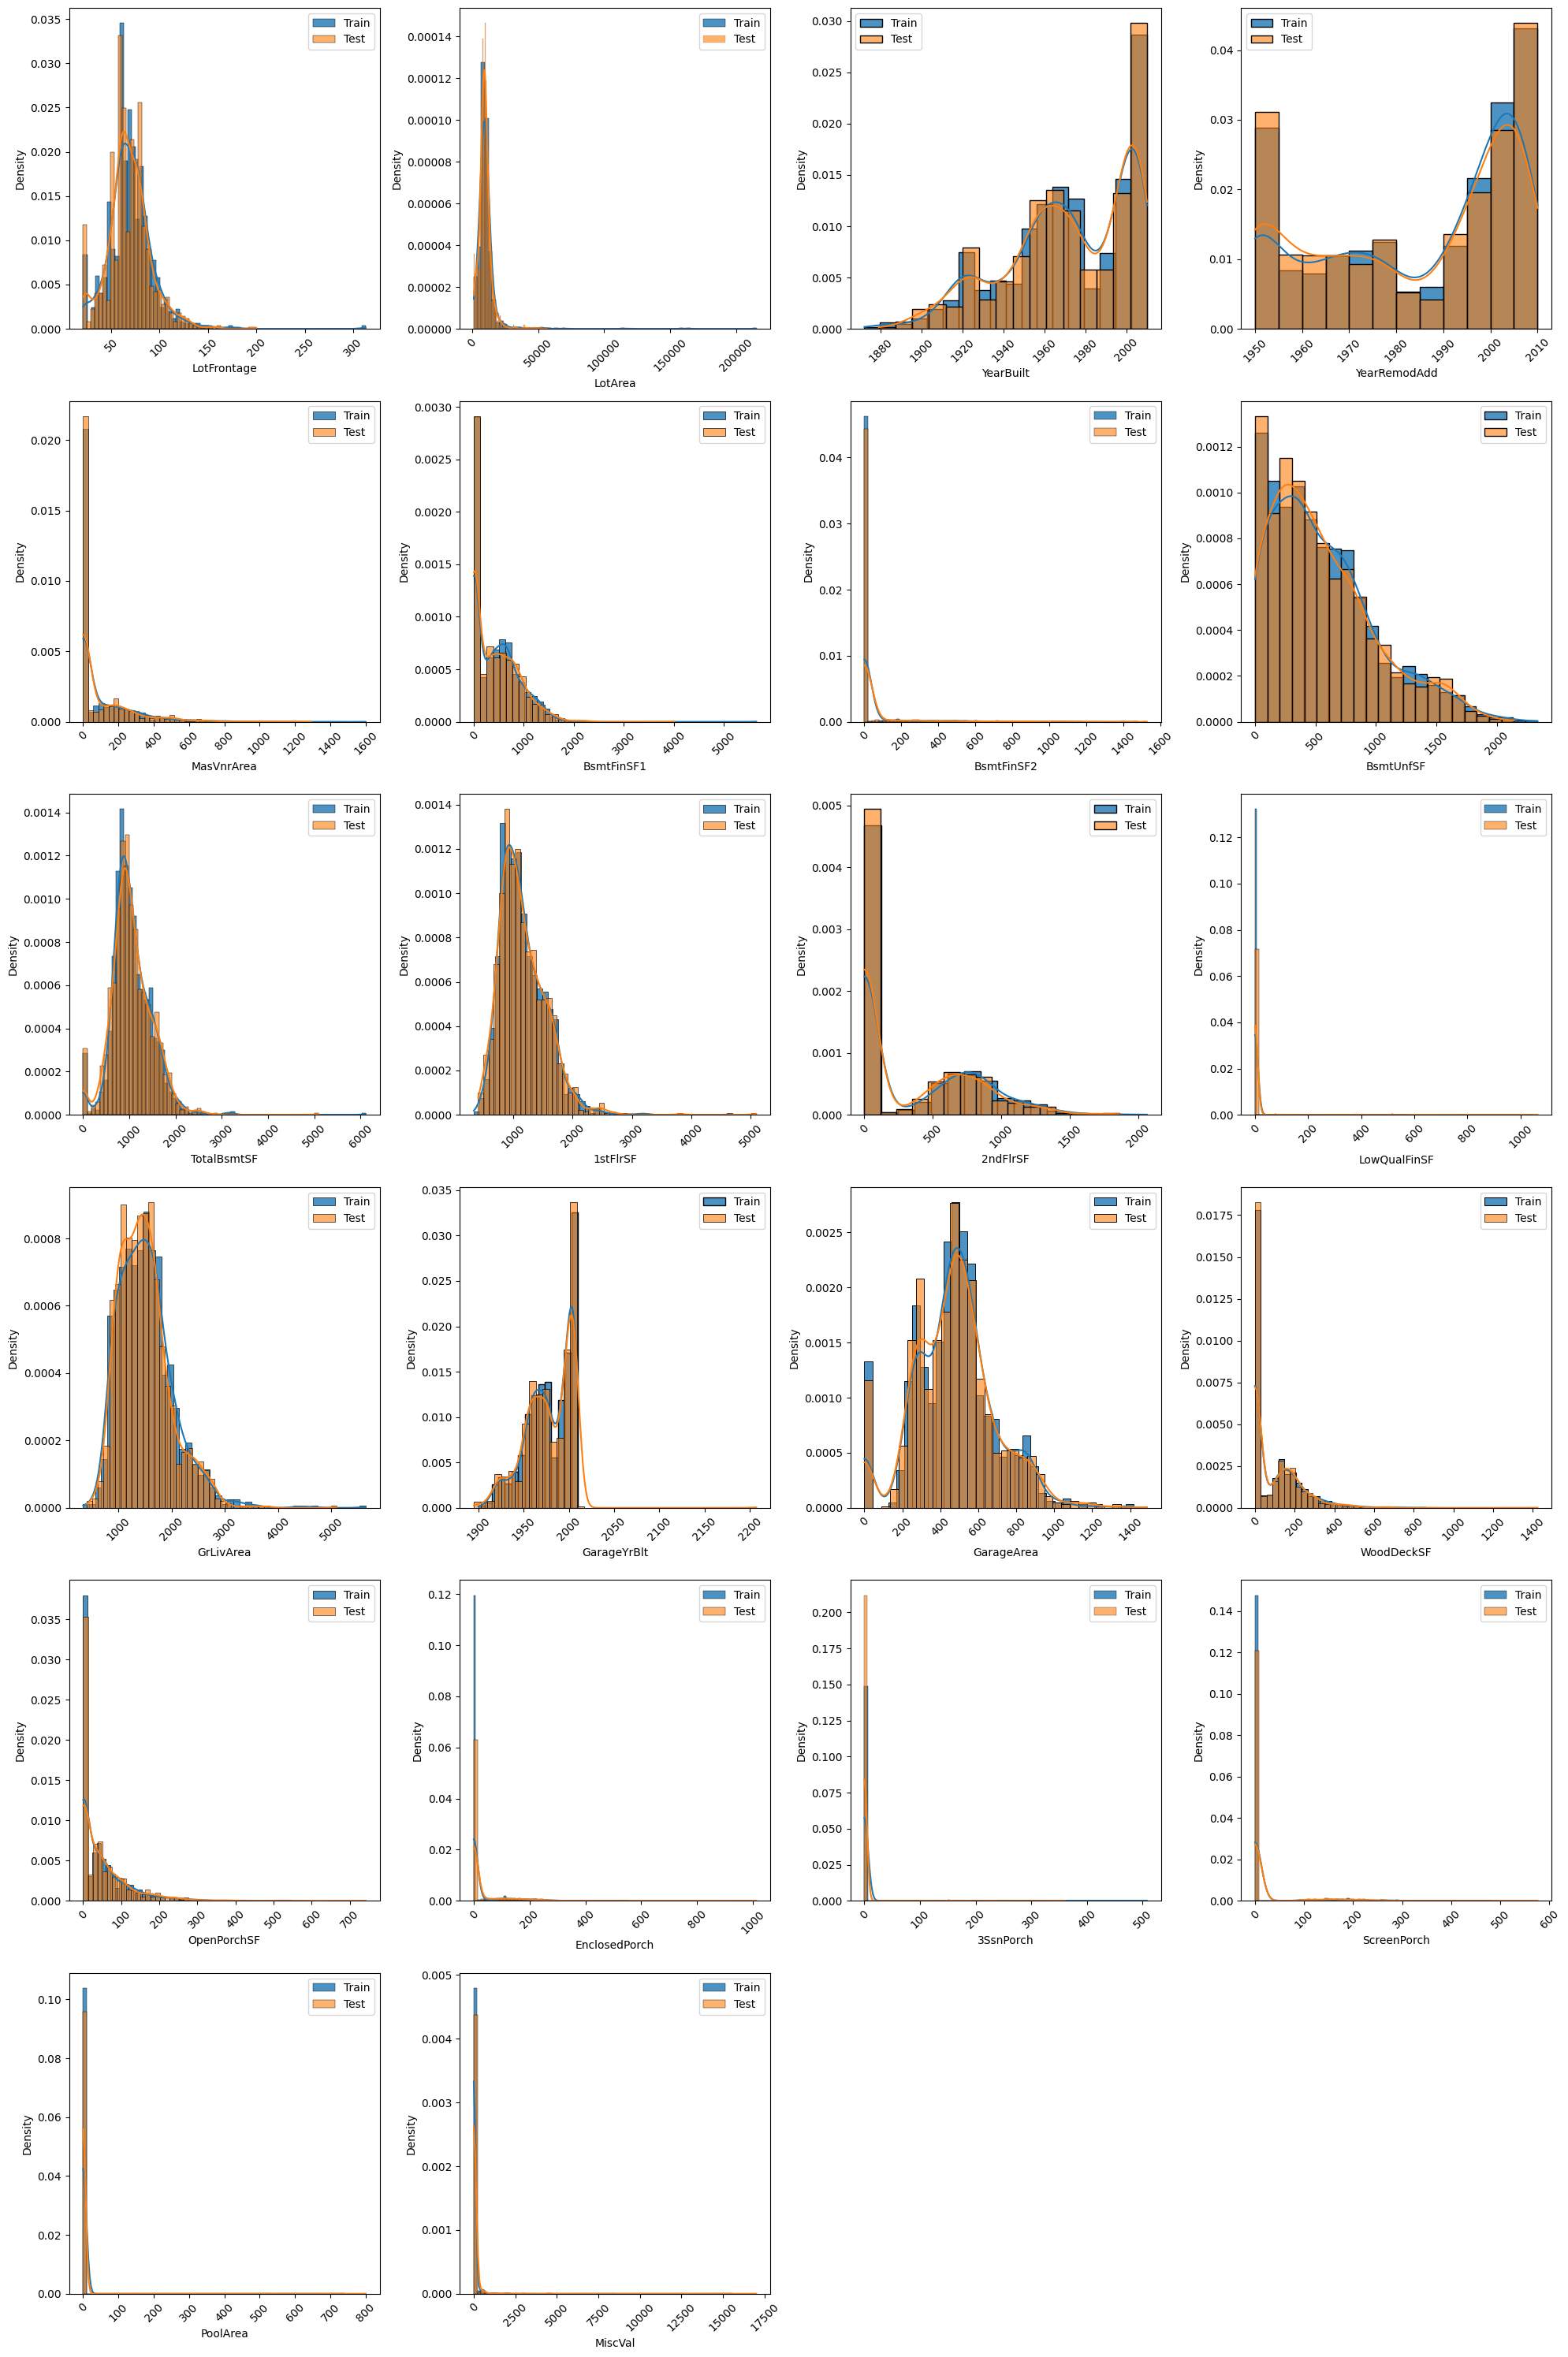

In [434]:
plot_univariate_subplot(train, test, quantitative)

In [28]:
results = []

# Test for normality using Shapiro-Wilk Test
test_normality = lambda x: stats.shapiro(x.dropna())[1] > 0.05

for col in ['SalePrice'] + quantitative:
    column_stats = {
        'column': col,
        'mean': train[col].mean(),
        'median': train[col].median(),
        'mode': train[col].mode().iloc[0],
        'std': train[col].std(),
        'skew': train[col].skew(),
        'kurt': train[col].kurt(),
        'min': train[col].min(),
        'max': train[col].max(),
        'normally distributed?': test_normality(train[col])
    }
    results.append(column_stats)

summary_df = pd.DataFrame(results)
summary_df.set_index('column', inplace=True)

summary_df

mean    median      mode           std       skew  \
column                                                                      
SalePrice      180921.195890  163000.0  140000.0  79442.502883   1.882876   
LotFrontage        70.049958      69.0      60.0     24.284752   2.163569   
LotArea         10516.828082    9478.5    7200.0   9981.264932  12.207688   
YearBuilt        1971.267808    1973.0    2006.0     30.202904  -0.613461   
YearRemodAdd     1984.865753    1994.0    1950.0     20.645407  -0.503562   
MasVnrArea        103.685262       0.0       0.0    181.066207   2.669084   
BsmtFinSF1        443.639726     383.5       0.0    456.098091   1.685503   
BsmtFinSF2         46.549315       0.0       0.0    161.319273   4.255261   
BsmtUnfSF         567.240411     477.5       0.0    441.866955   0.920268   
TotalBsmtSF      1057.429452     991.5       0.0    438.705324   1.524255   
1stFlrSF         1162.626712    1087.0     864.0    386.587738   1.376757   
2ndFlrSF          346.992466       0.0       0.0    436.528436   0.813030   
LowQualFinSF        5.844521       0.0       0.0     48.623081   9.011341   
GrLivArea        1515.463699    1464.0     864.0    525.480383   1.366560   
GarageYrBlt      1978.506164    1980.0    2005.0     24.689725  -0.649415   
GarageArea        472.980137     480.0       0.0    213.804841   0.179981   
WoodDeckSF         94.244521       0.0       0.0    125.338794   1.541376   
OpenPorchSF        46.660274      25.0       0.0     66.256028   2.364342   
EnclosedPorch      21.954110       0.0       0.0     61.119149   3.089872   
3SsnPorch           3.409589       0.0       0.0     29.317331  10.304342   
ScreenPorch        15.060959       0.0       0.0     55.757415   4.122214   
PoolArea            2.758904       0.0       0.0     40.177307  14.828374   
MiscVal            43.489041       0.0       0.0    496.123024  24.476794   

                     kurt      min       max  normally distributed?  
column                                                               
SalePrice        6.536282  34900.0  755000.0                  False  
LotFrontage     17.452867     21.0     313.0                  False  
LotArea        203.243271   1300.0  215245.0                  False  
YearBuilt       -0.439552   1872.0    2010.0                  False  
YearRemodAdd    -1.272245   1950.0    2010.0                  False  
MasVnrArea      10.082417      0.0    1600.0                  False  
BsmtFinSF1      11.118236      0.0    5644.0                  False  
BsmtFinSF2      20.113338      0.0    1474.0                  False  
BsmtUnfSF        0.474994      0.0    2336.0                  False  
TotalBsmtSF     13.250483      0.0    6110.0                  False  
1stFlrSF         5.745841    334.0    4692.0                  False  
2ndFlrSF        -0.553464      0.0    2065.0                  False  
LowQualFinSF    83.234817      0.0     572.0                  False  
GrLivArea        4.895121    334.0    5642.0                  False  
GarageYrBlt     -0.418341   1900.0    2010.0                  False  
GarageArea       0.917067      0.0    1418.0                  False  
WoodDeckSF       2.992951      0.0     857.0                  False  
OpenPorchSF      8.490336      0.0     547.0                  False  
EnclosedPorch   10.430766      0.0     552.0                  False  
3SsnPorch      123.662379      0.0     508.0                  False  
ScreenPorch     18.439068      0.0     480.0                  False  
PoolArea       223.268499      0.0     738.0                  False  
MiscVal        701.003342      0.0   15500.0                  False

All numerical features are not normally distributed.

Dataset shape: (1460, 81)
Numerical features: 38
Testing Id...
Testing MSSubClass...
Testing LotFrontage...
Testing LotArea...
Testing OverallQual...
Testing OverallCond...
Testing YearBuilt...
Testing YearRemodAdd...
Testing MasVnrArea...
Testing BsmtFinSF1...
Testing BsmtFinSF2...
Testing BsmtUnfSF...
Testing TotalBsmtSF...
Testing 1stFlrSF...
Testing 2ndFlrSF...
Testing LowQualFinSF...
Testing GrLivArea...
Testing BsmtFullBath...
Testing BsmtHalfBath...
Testing FullBath...
Testing HalfBath...
Testing BedroomAbvGr...
Testing KitchenAbvGr...
Testing TotRmsAbvGrd...
Testing Fireplaces...
Testing GarageYrBlt...
Testing GarageCars...
Testing GarageArea...
Testing WoodDeckSF...
Testing OpenPorchSF...
Testing EnclosedPorch...
Testing 3SsnPorch...
Testing ScreenPorch...
Testing PoolArea...
Testing MiscVal...
Testing MoSold...
Testing YrSold...
Testing SalePrice...

=== NORMALITY TEST RESULTS ===
Normal features: False/38 (0.0%)
Testing Id...
Testing MSSubClass...
Testing LotFrontage...
Test

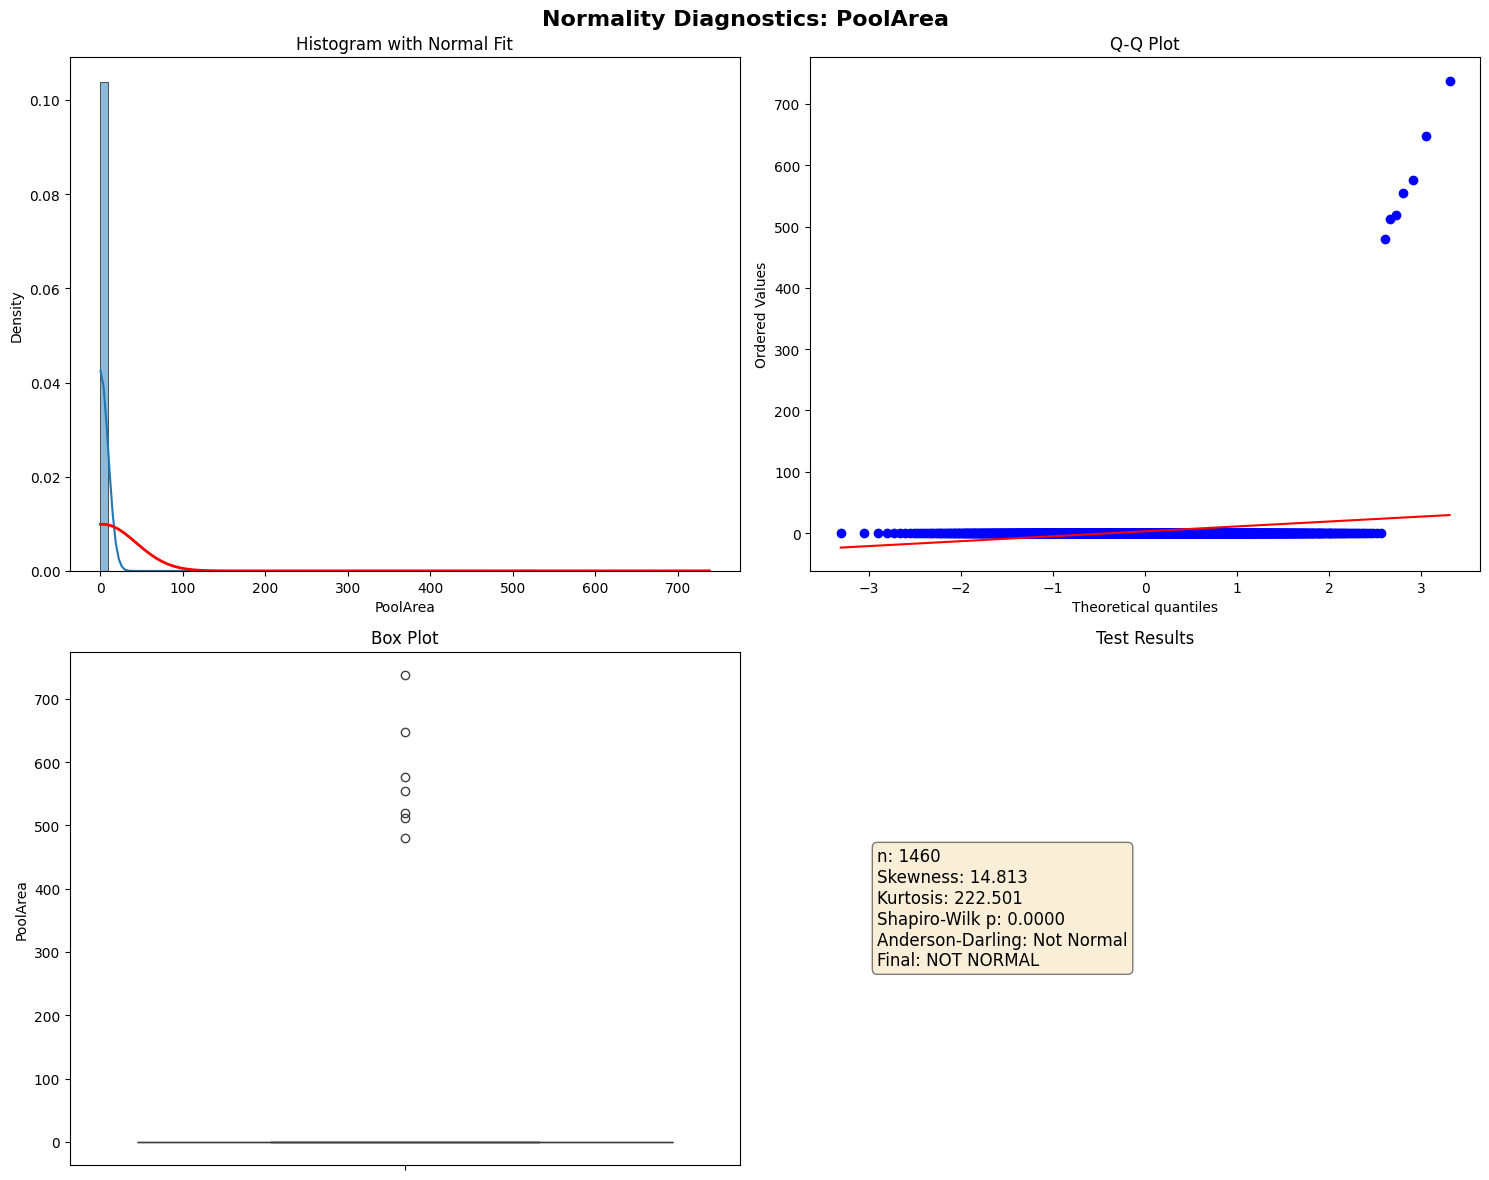


Most normal feature: GarageArea


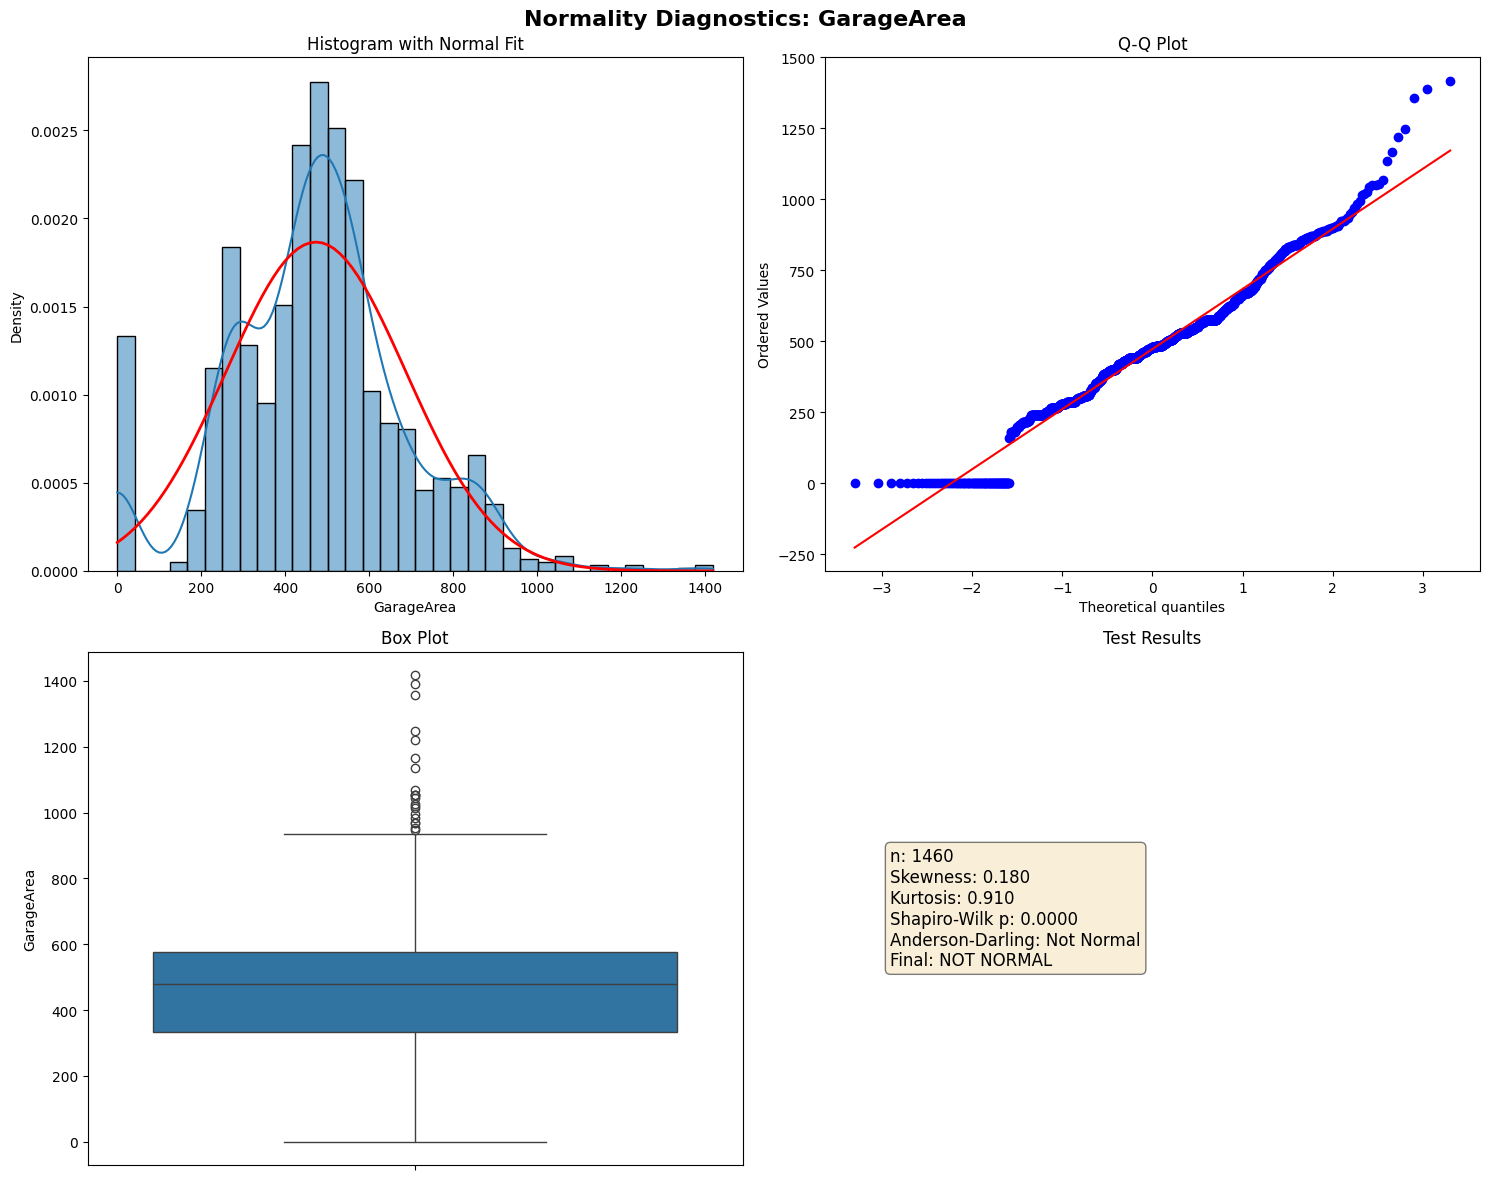

In [29]:
# NORMALITY TEST

def test_normality_1460(data, alpha=0.05, feature_name=""):
    """
    Comprehensive normality testing for medium-large samples (1460)
    """
    # Remove NaN values
    clean_data = data.dropna()
    n = len(clean_data)
    
    if n < 3:
        return {"normal": False, "test_used": "insufficient_data", "n": n}
    
    results = {}
    
    # 1. Shapiro-Wilk (good for n < 2000)
    try:
        shapiro_stat, shapiro_p = shapiro(clean_data)
        results['shapiro_p'] = shapiro_p
        results['shapiro_normal'] = shapiro_p > alpha
    except:
        results['shapiro_normal'] = False
    
    # 2. Anderson-Darling (good for all sample sizes)
    try:
        anderson_result = anderson(clean_data, dist='norm')
        # Use 5% significance level (index 2)
        results['anderson_stat'] = anderson_result.statistic
        results['anderson_normal'] = anderson_result.statistic < anderson_result.critical_values[2]
    except:
        results['anderson_normal'] = False
    
    # 3. Kolmogorov-Smirnov (good for large samples)
    try:
        mu, sigma = clean_data.mean(), clean_data.std()
        ks_stat, ks_p = kstest(clean_data, 'norm', args=(mu, sigma))
        results['ks_p'] = ks_p
        results['ks_normal'] = ks_p > alpha
    except:
        results['ks_normal'] = False
    
    # 4. D'Agostino's K² test (good for large samples)
    try:
        k2_stat, k2_p = normaltest(clean_data)
        results['dagostino_p'] = k2_p
        results['dagostino_normal'] = k2_p > alpha
    except:
        results['dagostino_normal'] = False
    
    # Final decision (majority vote)
    normal_tests = [results.get('shapiro_normal', False), 
                   results.get('anderson_normal', False),
                   results.get('ks_normal', False),
                   results.get('dagostino_normal', False)]
    
    results['normal'] = sum(normal_tests) >= 2  # At least 2 tests indicate normality
    results['n'] = n
    results['skewness'] = stats.skew(clean_data)
    results['kurtosis'] = stats.kurtosis(clean_data)
    
    return results

def test_normality_batch(df, numerical_features, alpha=0.05):
    """
    Test normality for all numerical features in dataframe
    """
    results = {}
    
    for feature in numerical_features:
        print(f"Testing {feature}...")
        results[feature] = test_normality_1460(df[feature], alpha, feature)
    
    # Create results DataFrame
    results_df = pd.DataFrame(results).T
    
    # Calculate summary statistics
    results_df['is_normal'] = results_df['normal']
    normal_count = results_df['is_normal'].sum()
    total_count = len(results_df)
    
    print(f"\n=== NORMALITY TEST RESULTS ===")
    print(f"Normal features: {normal_count}/{total_count} ({normal_count/total_count*100:.1f}%)")
    
    return results_df.sort_values('is_normal', ascending=False)

def plot_normality_diagnostics(df, feature):
    """
    Create comprehensive normality diagnostic plots
    """
    data = df[feature].dropna()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Normality Diagnostics: {feature}', fontsize=16, fontweight='bold')
    
    # 1. Histogram with normal curve
    sns.histplot(data, kde=True, stat='density', ax=axes[0, 0])
    mu, sigma = data.mean(), data.std()
    x = np.linspace(data.min(), data.max(), 100)
    axes[0, 0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2)
    axes[0, 0].set_title('Histogram with Normal Fit')
    
    # 2. Q-Q Plot
    stats.probplot(data, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot')
    
    # 3. Box plot
    sns.boxplot(y=data, ax=axes[1, 0])
    axes[1, 0].set_title('Box Plot')
    
    # 4. Statistical test results
    test_results = test_normality_1460(data, feature_name=feature)
    textstr = '\n'.join([
        f'n: {test_results["n"]}',
        f'Skewness: {test_results["skewness"]:.3f}',
        f'Kurtosis: {test_results["kurtosis"]:.3f}',
        f'Shapiro-Wilk p: {test_results.get("shapiro_p", "N/A"):.4f}',
        f'Anderson-Darling: {"Normal" if test_results.get("anderson_normal", False) else "Not Normal"}',
        f'Final: {"NORMAL" if test_results["normal"] else "NOT NORMAL"}'
    ])
    
    axes[1, 1].text(0.1, 0.5, textstr, transform=axes[1, 1].transAxes, fontsize=12,
                   verticalalignment='center', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Test Results')
    
    plt.tight_layout()
    plt.show()
    
    return test_results

def generate_normality_report(df, numerical_features, alpha=0.05):
    """
    Generate comprehensive normality report
    """
    results = test_normality_batch(df, numerical_features, alpha)
    
    print("=" * 80)
    print("COMPREHENSIVE NORMALITY REPORT")
    print("=" * 80)
    
    # Summary statistics
    normal_features = results[results['is_normal']].index.tolist()
    non_normal_features = results[~results['is_normal']].index.tolist()
    
    print(f"\nNORMAL FEATURES ({len(normal_features)}):")
    print(", ".join(normal_features[:10]) + ("..." if len(normal_features) > 10 else ""))
    
    print(f"\nNON-NORMAL FEATURES ({len(non_normal_features)}):")
    print(", ".join(non_normal_features[:10]) + ("..." if len(non_normal_features) > 10 else ""))
    
    # Skewness and Kurtosis analysis
    print(f"\nSKEWNESS ANALYSIS:")
    print(f"Mean skewness: {results['skewness'].mean():.3f}")
    print(f"Max skewness: {results['skewness'].max():.3f} ({results['skewness'].idxmax()})")
    print(f"Min skewness: {results['skewness'].min():.3f} ({results['skewness'].idxmin()})")
    
    print(f"\nKURTOSIS ANALYSIS:")
    print(f"Mean kurtosis: {results['kurtosis'].mean():.3f}")
    print(f"Max kurtosis: {results['kurtosis'].max():.3f} ({results['kurtosis'].idxmax()})")
    print(f"Min kurtosis: {results['kurtosis'].min():.3f} ({results['kurtosis'].idxmin()})")
    
    return results



# For your 1460-sample dataset
def analyze_dataset_normality(df):
    """
    Complete normality analysis for your dataset
    """
    # Identify numerical features
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"Dataset shape: {df.shape}")
    print(f"Numerical features: {len(numerical_features)}")
    
    # Test normality
    normality_results = test_normality_batch(df, numerical_features)
    
    # Generate report
    report = generate_normality_report(df, numerical_features)
    
    # Plot diagnostics for the most non-normal feature
    most_non_normal = normality_results.sort_values('shapiro_p').index[0]
    print(f"\nMost non-normal feature: {most_non_normal}")
    plot_normality_diagnostics(df, most_non_normal)
    
    # Plot diagnostics for the most normal feature
    most_normal = normality_results.sort_values('shapiro_p', ascending=False).index[0]
    print(f"\nMost normal feature: {most_normal}")
    plot_normality_diagnostics(df, most_normal)
    
    return normality_results


normality_results = analyze_dataset_normality(train)

## 4.2. Bivariate analysis

Understand the relationships between features and the target variable using scatterplots, correlation coefficients / matrix.

In [30]:
def plot_bivariate(df, col, ax=None):
    """ plot scatter or boxplot of SalePrice vs col on specified axes """

    if ax is None:
        ax = plt.gca()
        
    if col in qualitative:
        # for categorical variables
        sns.boxplot(x=col, y='SalePrice', data=df, ax=ax)
    else:
        # for numerical variables
        sns.regplot(x=col, y='SalePrice', data=df, line_kws={'color': 'red'}, ax=ax)

    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel(col)

In [31]:
def plot_bivariate_subplot(df, col_list):
    """
    Display a subplot of the bivariate analysis for the columns in col_list of the dataframe df
    """    
    if col_list == qualitative:
        fig, axes = plt.subplots(nrows=15, ncols=4, figsize=(20, 60))
    else:
        fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 30))
    
    # Flatten the 2D axes array for easier iteration
    axes_flat = axes.flatten()
    
    for i, ax in enumerate(axes_flat):
        if i < len(col_list):
            plot_bivariate(df, col_list[i], ax=ax)
        else:
            # Hide unused subplots if you have fewer than 44 columns
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

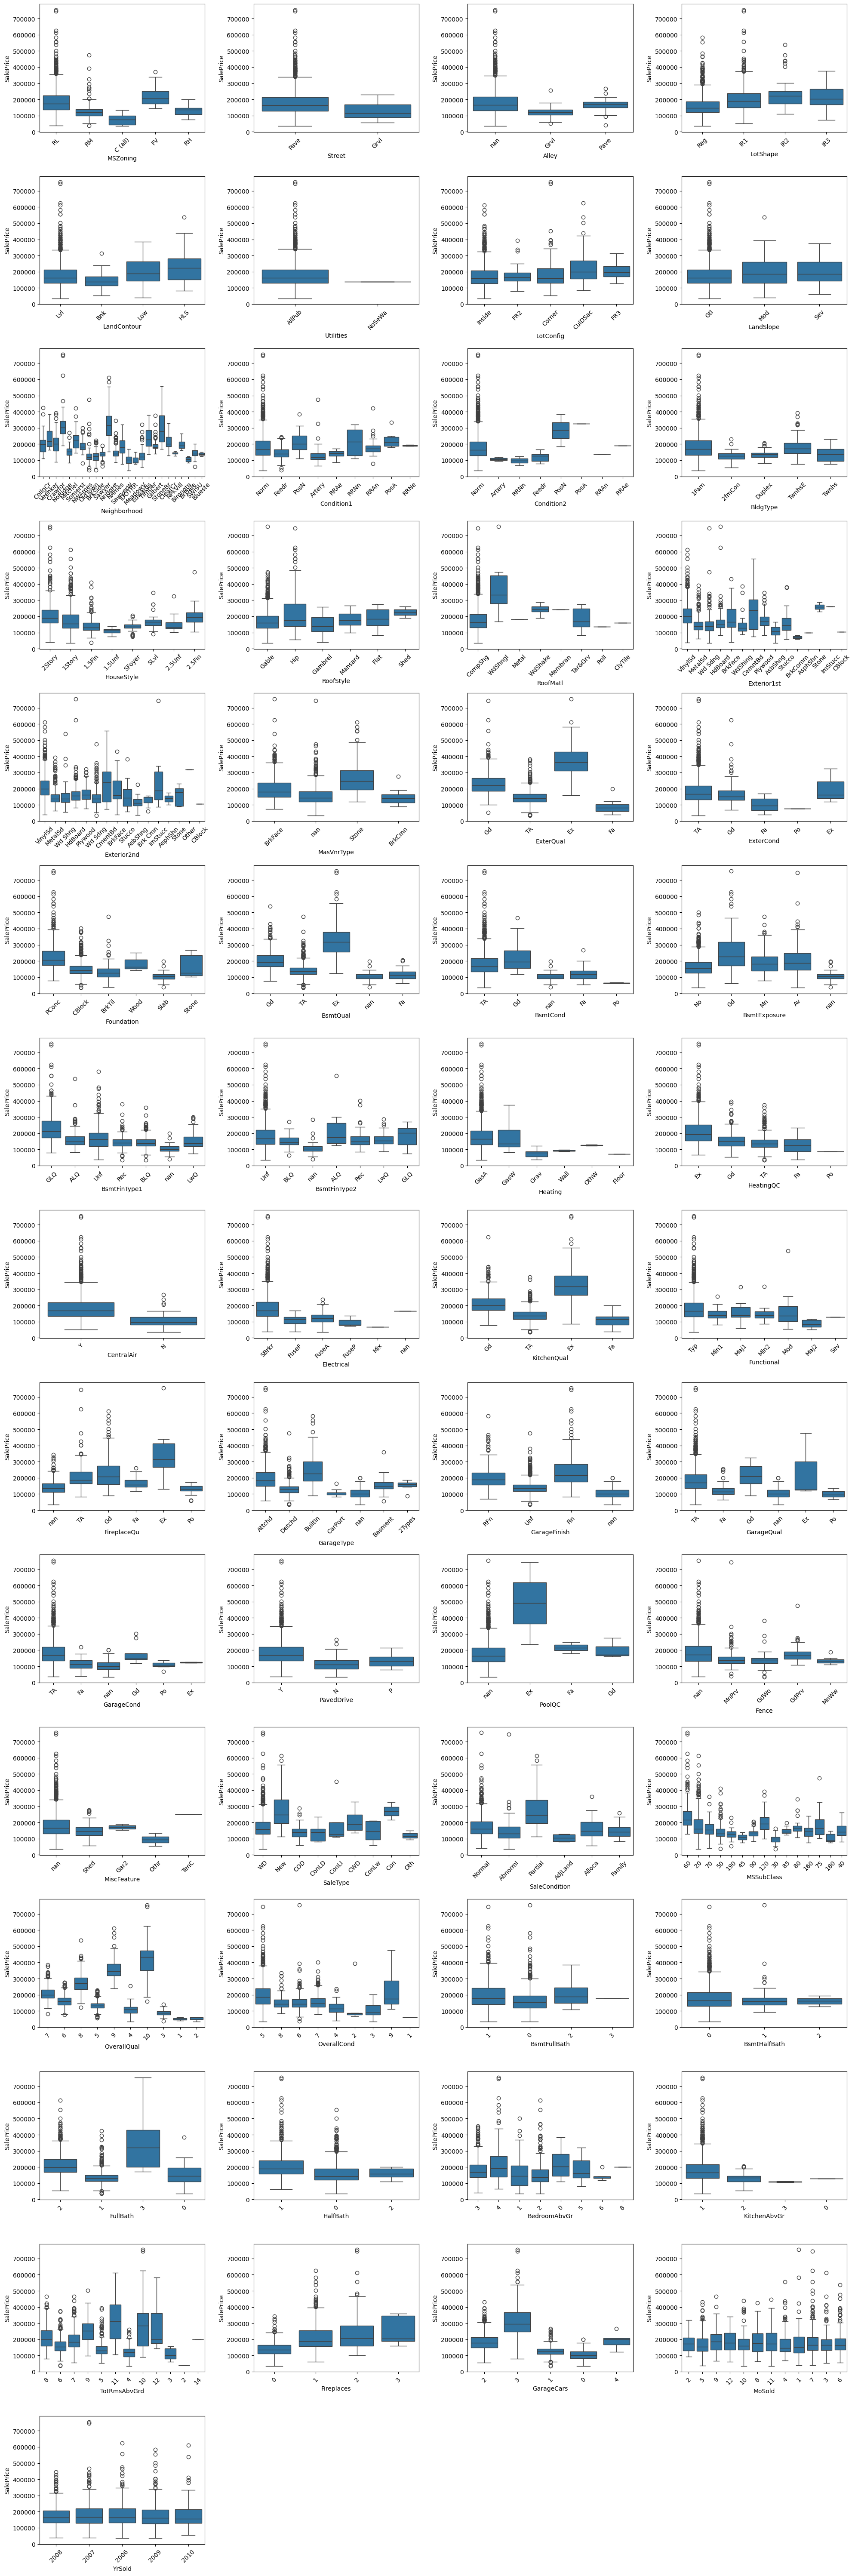

In [439]:
plot_bivariate_subplot(train, qualitative)

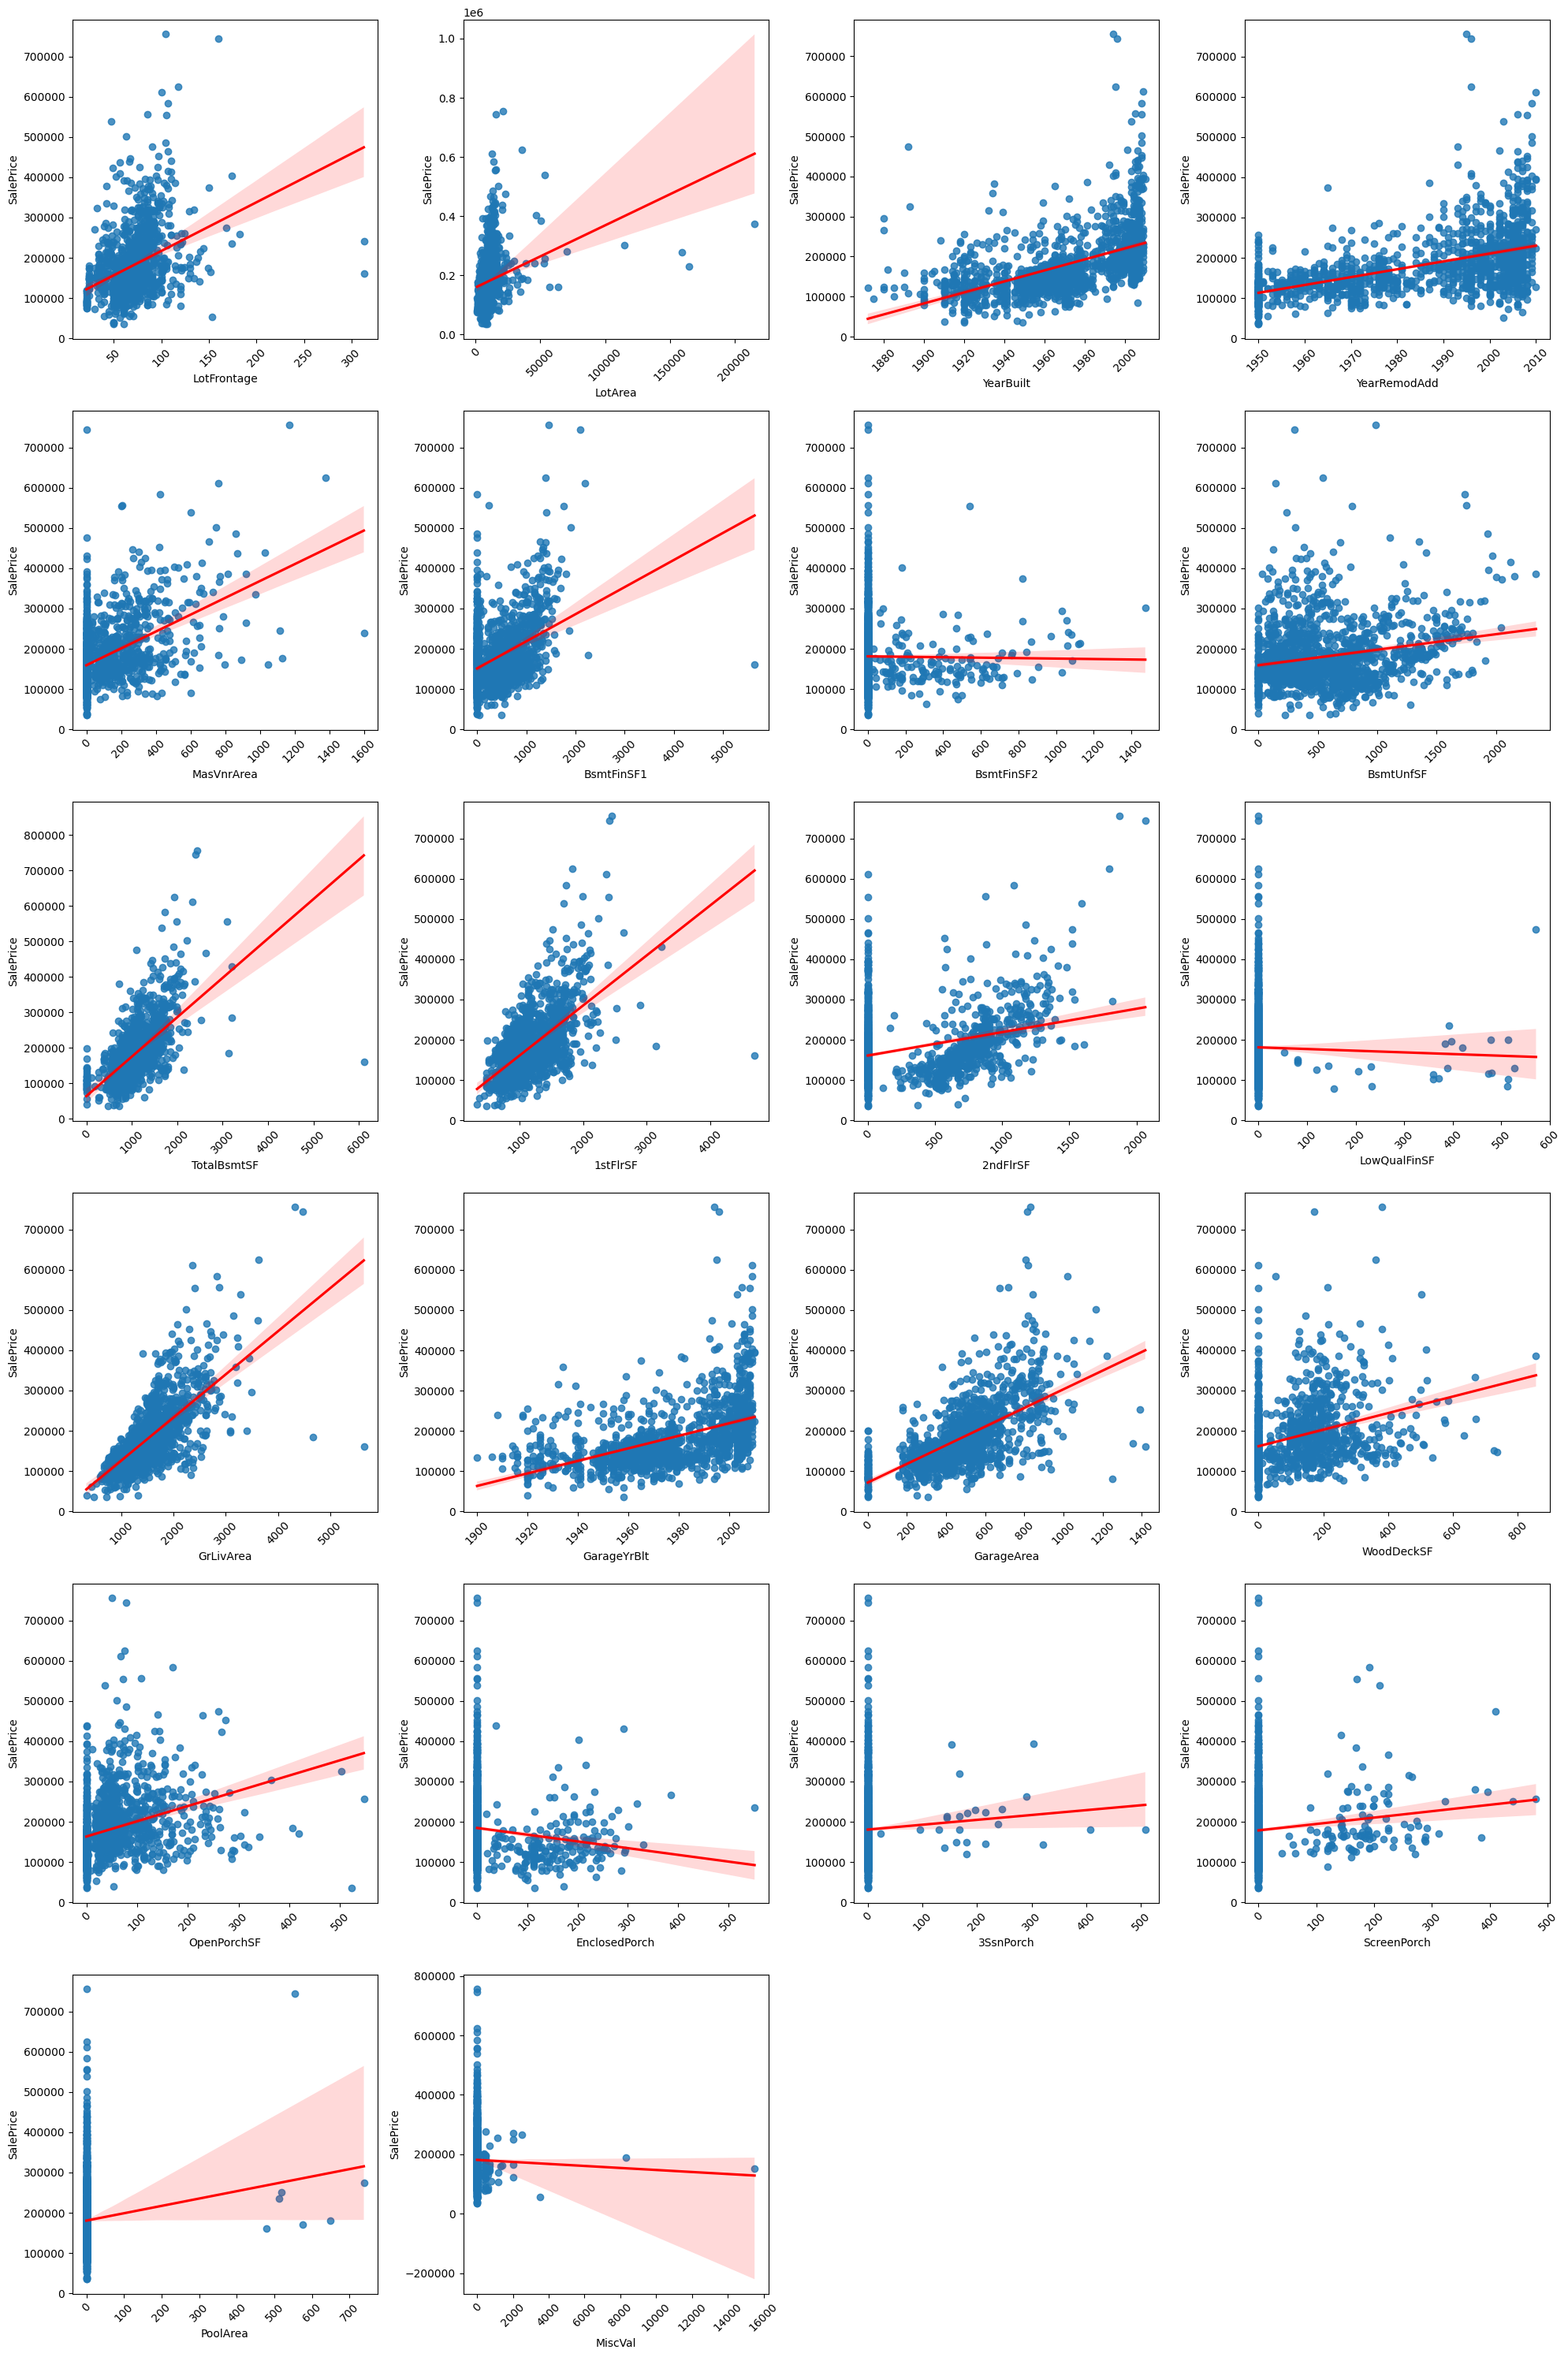

In [440]:
plot_bivariate_subplot(train, quantitative)

Some features have a lot of zeros values, meaning that the house does not have the specific attribute (bathroom, pool, porch, etc...). It might be worth converting these numerical features into categorical.

Some features correlate well with SalePrice, but many don't.

## 4.3. Handle Outliers

In [32]:
train[train['TotalBsmtSF'] > 6000]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
1298         Bnk    AllPub  ...      480     Gd   NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1298      1   2008       New        Partial     160000  

[1 rows x 81 columns]

In [33]:
train[train['BsmtFinSF1'] > 5000]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
1298         Bnk    AllPub  ...      480     Gd   NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1298      1   2008       New        Partial     160000  

[1 rows x 81 columns]

In [34]:
train[train['GrLivArea'] > 5000]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
1298         Bnk    AllPub  ...      480     Gd   NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1298      1   2008       New        Partial     160000  

[1 rows x 81 columns]

In [35]:
train[train['MiscVal'] > 10000]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
346  347          20       RL          NaN    12772   Pave   NaN      IR1   

    LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
346         Lvl    AllPub  ...        0    NaN   NaN        Gar2   15500   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
346      4   2007        WD         Normal     151500  

[1 rows x 81 columns]

In [36]:
train[train['EnclosedPorch'] > 500]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
197  198          75       RL        174.0    25419   Pave   NaN      Reg   

    LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
197         Lvl    AllPub  ...      512     Ex  GdPrv         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
197      3   2006        WD        Abnorml     235000  

[1 rows x 81 columns]

In [37]:
train[train['LotFrontage'] > 300]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
934    935          20       RL        313.0    27650   Pave   NaN      IR2   
1298  1299          60       RL        313.0    63887   Pave   NaN      IR3   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
934          HLS    AllPub  ...        0    NaN   NaN         NaN       0   
1298         Bnk    AllPub  ...      480     Gd   NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
934      11   2008        WD         Normal     242000  
1298      1   2008       New        Partial     160000  

[2 rows x 81 columns]

In [38]:
test[test['GarageYrBlt'] > 2010]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1132  2593          20       RL         68.0     8298   Pave   NaN      IR1   

     LandContour Utilities  ... ScreenPorch PoolArea PoolQC Fence MiscFeature  \
1132         HLS    AllPub  ...           0        0    NaN   NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  
1132       0      9    2007       New        Partial  

[1 rows x 80 columns]

In [39]:
test.loc[test['Id'] == 2593, 'GarageYrBlt']

1132    2207.0
Name: GarageYrBlt, dtype: float64

This value is a  mistake, the year is in the future. Let's replace it with the median year.

In [40]:
# Calculate median GarageYrBlt (excluding NaN values if any)
median_garage_year = train['GarageYrBlt'].median()

# Replace the erroneous value
test.loc[test['Id'] == 2593, 'GarageYrBlt'] = median_garage_year

# Verify the change
print(f"Replaced value: {test.loc[test['Id'] == 2593, 'GarageYrBlt'].values[0]}")

Replaced value: 1980.0


It looks like the house with Id 1299 and 935 has many outlier features. Let's drop it so that it does not affect the predictions.

In [41]:
train = train[train['Id'] != 1299]
train = train[train['Id'] != 935]

## 4.4. Handle missing values

For numerical columns, replace NaN by the mean of the column. Use SimpleImputer to prevent data leakage.

In [42]:
def impute_missing_values_mean(train_df, test_df, column_name):
    """ replace NaN by mean of the (numerical) column """
    
    imputer = SimpleImputer(strategy='mean')
    
    # Fit on training data, transform both
    train_df[column_name] = imputer.fit_transform(train_df[[column_name]])
    test_df[column_name] = imputer.transform(test_df[[column_name]])
    
    return train_df, test_df

train, test = impute_missing_values_mean(train, test, 'LotFrontage')

In [43]:
def impute_missing_values_median(train_df, test_df, column_name):
    """ replace NaN by median of the (numerical) column """
    
    imputer = SimpleImputer(strategy='median')
    
    # Fit on training data, transform both
    train_df[column_name] = imputer.fit_transform(train_df[[column_name]])
    test_df[column_name] = imputer.transform(test_df[[column_name]])
    
    return train_df, test_df

train, test = impute_missing_values_median(train, test, 'GarageYrBlt')

For categorical features, replace NaN values by 'No'.

In [44]:
drop_nan_categorical = ['Alley', 'Fence', 'FireplaceQu', 'MasVnrType', 'MiscFeature', 'PoolQC']

for col in drop_nan_categorical:
    train[col] = train[col].fillna('No')
    test[col] = test[col].fillna('No')

These numerical features have many 0s. Let's :
1. create a new categorical features by setting the zeros values as 0 and non-zeros as 1
2. change the old numerical feature by replacing 0 by NaN

In [45]:
new_num_feat = ['2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'LowQualFinSF', 'MasVnrArea', 
'MiscVal', 'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF']

for col in new_num_feat:

    # create new categorical feature from the numerical feature by setting the zeros values as 0 and non-zeros as 1
    new_col_name = col + '_cat'
    train[new_col_name] = (train[col] != 0).astype('int64')
    test[new_col_name] = (test[col] != 0).astype('int64')

    # add to qualitative list
    qualitative.append(new_col_name)

    # replace the 0s by NaN
    train[col] = train[col].replace(0, np.nan)
    test[col] = test[col].replace(0, np.nan)

# 5. Feature engineering

## 5.1. Create new features

Let's engineer relevant features that might improve predictive performance.

For the "year" features (YearBuilt, YearRemodAdd, GarageYrBlt), replace by the age (which is more representative), apply a square to capture non-linearity and categorise by the decade.

In [46]:
def convert_years(df):
    """ 
    Create new features from the "year" features 
    """

    df['House_Age'] = (2011 - df['YearBuilt']).astype('int64')
    df['House_Age_Squared'] = df['House_Age']**2
    df['House_Decade_Built'] = ((df['YearBuilt'] // 10) * 10).astype('int64')

    df['Garage_Age'] = (2011 - df['GarageYrBlt']).astype('int64')
    df['Garage_Age_Squared'] = df['Garage_Age']**2
    df['Garage_Decade_Built'] = ((df['GarageYrBlt'] // 10) * 10).astype('int64')
    
    df['Remodel_Age'] = (2011 - df['YearRemodAdd']).astype('int64')
    df['Remodel_Age_Squared'] = df['Remodel_Age']**2
    df['Remodel_Decade_Built'] = ((df['YearRemodAdd'] // 10) * 10).astype('int64')

convert_years(train)
convert_years(test)

In [47]:
# remove old features

columns_to_drop = ['YearBuilt', 'GarageYrBlt', 'YearRemodAdd']

train = train.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)

# update qualitative and quantitative lists
qualitative += ['House_Decade_Built', 'Garage_Decade_Built', 'Remodel_Decade_Built']
quantitative += ['House_Age', 'House_Age_Squared', 'Garage_Age', 'Garage_Age_Squared', 'Remodel_Age', 'Remodel_Age_Squared']

quantitative.remove('YearBuilt')
quantitative.remove('GarageYrBlt')
quantitative.remove('YearRemodAdd')

## 5.2. Encode categorical features

Let's convert categorical features into numerical form using techniques like one-hot encoding, label encoding or target encoding.

Note : using drop_first=True creates 1 column instead of 2 for 2 categories (dummy variable trapping). This avoids multicollinearity between columns.

Let's perform target encoding on categorical features, using the target variable 'SalePrice' to create numerical representations. This encoding preserves the relationship between categorical values and the target variable, which can improve model performance compared to simple label encoding or one-hot encoding for tree-based models.

In [48]:
for col in qualitative:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

In [49]:
print_missing_values(train)

zeros_count  blanks_count  nan_count  none_count  zeros_%  \
PoolArea                 0             0       1452           0      0.0   
3SsnPorch                0             0       1434           0      0.0   
LowQualFinSF             0             0       1432           0      0.0   
MiscVal                  0             0       1406           0      0.0   
ScreenPorch              0             0       1342           0      0.0   
BsmtFinSF2               0             0       1291           0      0.0   
EnclosedPorch            0             0       1250           0      0.0   
MasVnrArea               0             0        868           0      0.0   
2ndFlrSF                 0             0        828           0      0.0   
WoodDeckSF               0             0        760           0      0.0   
OpenPorchSF              0             0        655           0      0.0   
BsmtFinSF1               0             0        467           0      0.0   
BsmtUnfSF                0             0        118           0      0.0   
GarageArea               0             0         81           0      0.0   
TotalBsmtSF              0             0         37           0      0.0   

               blanks_%  nan_%  none_%  
PoolArea            0.0   99.6     0.0  
3SsnPorch           0.0   98.4     0.0  
LowQualFinSF        0.0   98.2     0.0  
MiscVal             0.0   96.4     0.0  
ScreenPorch         0.0   92.0     0.0  
BsmtFinSF2          0.0   88.5     0.0  
EnclosedPorch       0.0   85.7     0.0  
MasVnrArea          0.0   59.5     0.0  
2ndFlrSF            0.0   56.8     0.0  
WoodDeckSF          0.0   52.1     0.0  
OpenPorchSF         0.0   44.9     0.0  
BsmtFinSF1          0.0   32.0     0.0  
BsmtUnfSF           0.0    8.1     0.0  
GarageArea          0.0    5.6     0.0  
TotalBsmtSF         0.0    2.5     0.0

In [50]:
def encode(df, col):
    """ 
    Converts categorical variables into numerical values based on the mean SalePrice for each category.
    """
    
    ordering = pd.DataFrame()
    ordering['val'] = df[col].unique()
    ordering.index = ordering.val
    ordering['spmean'] = df[[col, 'SalePrice']].groupby(col).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        df.loc[df[col] == cat, col+'_E'] = o
    
qualitative_encoded = []
for col in qualitative:  
    encode(train, col)
    qualitative_encoded.append(col+'_E')
    
print(qualitative_encoded)

# train = pd.get_dummies(train).reset_index(drop=True)
# train.shape

/tmp/ipykernel_26590/2782942767.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df[col] == cat, col+'_E'] = o
/tmp/ipykernel_26590/2782942767.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df[col] == cat, col+'_E'] = o
/tmp/ipykernel_26590/2782942767.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use 

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E', 'MSSubClass_E', 'OverallQual_E', 'OverallCond_E', 'BsmtFullBath_E', 'BsmtHalfBath_E', 'FullBath_E', 'HalfBath_E', 'BedroomAbvGr_E', 'KitchenAbvGr_E', 'TotRmsAbvGrd_E', 'Fireplaces_E', 'GarageCars_E', 'MoSold_E', 'YrSold_E', '2ndFlrSF_cat_E', '3SsnPorch_cat_E', 'BsmtFinSF1_cat_E', 'BsmtFinSF2_cat_E', 'BsmtUnfSF_cat_E', 'EnclosedPorch

/tmp/ipykernel_26590/2782942767.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df[col] == cat, col+'_E'] = o
/tmp/ipykernel_26590/2782942767.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df[col] == cat, col+'_E'] = o
/tmp/ipykernel_26590/2782942767.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use 

In [57]:
# Combine numerical and encoded categorical features
all_features = quantitative + qualitative_encoded 
all_features.append('SalePrice')

## 5.3. Feature selection

Let's remove features that do not contribute much to the prediction, such as colinear features or features poorly correlated with the target variable.

Many ML algorithms, such as Random Forest, provide a feature importance score.

This improves the model's stability and interpretability, and reduces overfitting. 

The Spearman correlation coefficient is able to pick up relationships between variables even when they are nonlinear.

The Utilities feature is too imbalanced and does not bring any insight. Let's drop it.

In [55]:
# Select top features
#selector = SelectKBest(score_func=f_regression, k=20)
#X_selected = selector.fit_transform(X_train, y_train)

# Get selected feature names (includes both positive and negative correlations)
#selected_features = X_train.columns[selector.get_support()]

NameError: name 'X_train' is not defined

In [58]:
# Calculate correlation matrix
correlation_matrix = train[all_features].corr()

# Get correlations with SalePrice and sort them
saleprice_corr = correlation_matrix['SalePrice'].sort_values(ascending=False)

print("Top correlated features :")
print(saleprice_corr.head(10))

print("Least correlated features :")
print(saleprice_corr.tail(10))

Top correlated features :
SalePrice         1.000000
OverallQual_E     0.793610
GrLivArea         0.725438
Neighborhood_E    0.697369
GarageCars_E      0.692483
ExterQual_E       0.685609
2ndFlrSF          0.673882
KitchenQual_E     0.661030
TotalBsmtSF       0.648644
1stFlrSF          0.625772
Name: SalePrice, dtype: float64
Least correlated features :
YrSold_E               0.040782
BsmtHalfBath_E         0.016765
Utilities_E            0.014308
PoolArea              -0.167738
Garage_Age_Squared    -0.358802
House_Age_Squared     -0.409126
Garage_Age            -0.467826
Remodel_Age_Squared   -0.479160
Remodel_Age           -0.507271
House_Age             -0.523722
Name: SalePrice, dtype: float64


Text(0.5, 1.0, 'Top Features Correlation with SalePrice')

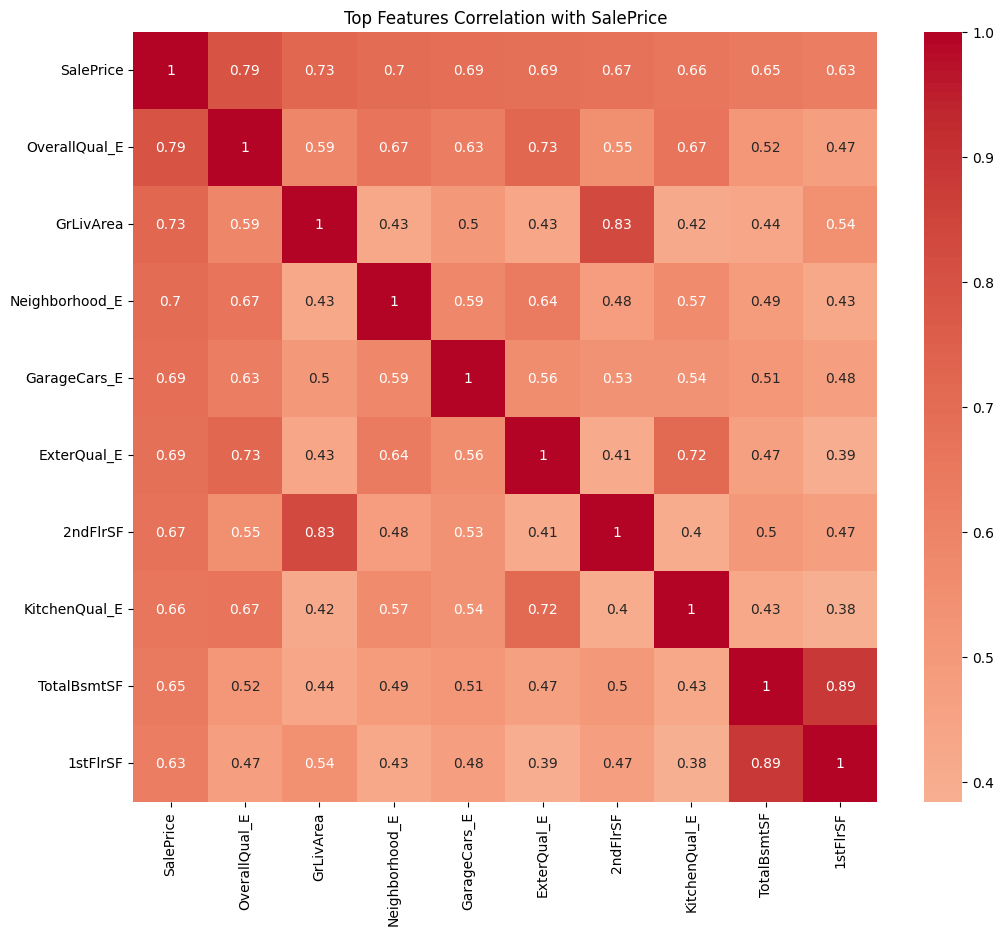

In [59]:
# Correlation heatmap

plt.figure(figsize=(12, 10))
# Get top 20 correlated features
top_features = saleprice_corr.head(10).index
top_corr_matrix = train[top_features].corr()

sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Top Features Correlation with SalePrice')

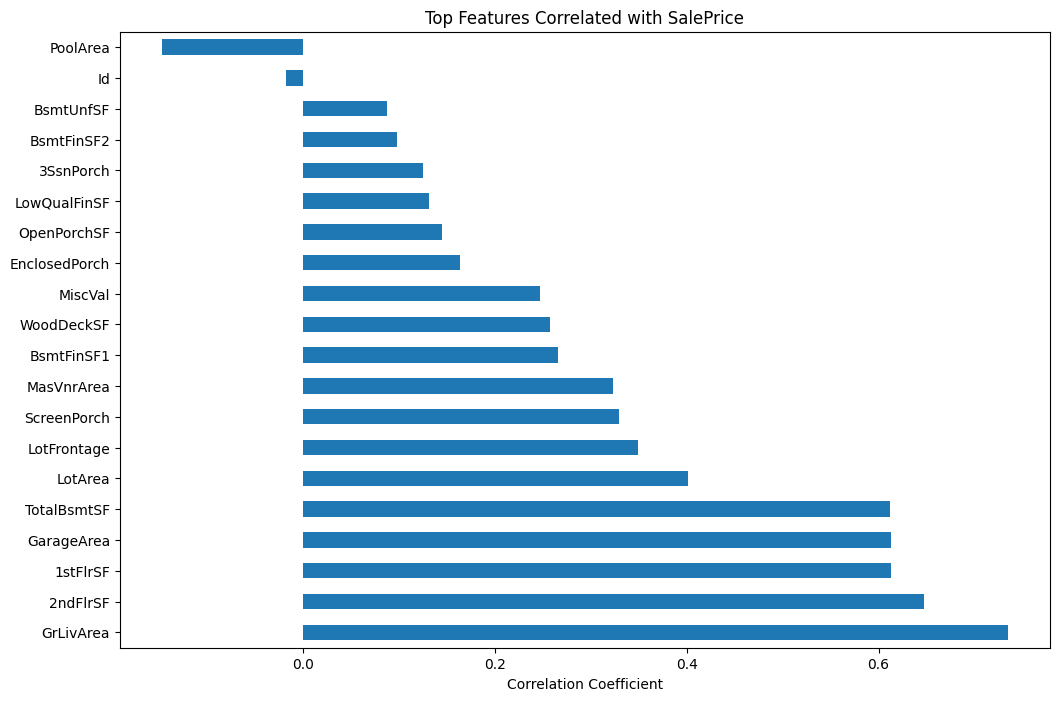

In [400]:
plt.figure(figsize=(12, 8))
saleprice_corr.drop('SalePrice').head(20).plot(kind='barh')
plt.title('Top Features Correlated with SalePrice')
plt.xlabel('Correlation Coefficient')
plt.show()

In [401]:
# Include your encoded categorical features
all_features = quantitative + qualitative_encoded 
all_features.append('SalePrice')

# Calculate correlation including encoded categoricals
full_corr = train[all_features].corr()
saleprice_full_corr = full_corr['SalePrice'].sort_values(ascending=False)

print("Top correlated features (including encoded categoricals):")
print(saleprice_full_corr.head(20))

Top correlated features (including encoded categoricals):
SalePrice                 1.000000
OverallQual_E             0.819572
Neighborhood_E            0.746283
GrLivArea                 0.734634
GarageCars_E              0.694921
ExterQual_E               0.681620
KitchenQual_E             0.669061
BsmtQual_E                0.648534
2ndFlrSF                  0.647496
House_Decade_Built_E      0.626466
1stFlrSF                  0.613401
GarageArea                0.612948
TotalBsmtSF               0.612391
GarageFinish_E            0.605409
FullBath_E                0.595798
GarageType_E              0.575599
MSSubClass_E              0.560486
Foundation_E              0.551447
Garage_Decade_Built_E     0.549519
Remodel_Decade_Built_E    0.547419
Name: SalePrice, dtype: float64


In [403]:
print(saleprice_full_corr.tail(20))

MiscFeature_E          0.093170
PoolQC_E               0.087659
BsmtUnfSF              0.087530
MoSold_E               0.082287
PoolArea_cat_E         0.076567
MiscVal_cat_E          0.073345
3SsnPorch_cat_E        0.057949
Street_E               0.057350
LowQualFinSF_cat_E     0.056936
YrSold_E               0.043904
LandSlope_E            0.036495
BsmtFinSF2_cat_E       0.034491
BsmtHalfBath_E         0.005014
PoolArea              -0.146659
Remodel_Age_Squared   -0.548128
Remodel_Age           -0.550297
Garage_Age            -0.564174
Garage_Age_Squared    -0.564760
House_Age_Squared     -0.627620
House_Age             -0.628839
Name: SalePrice, dtype: float64


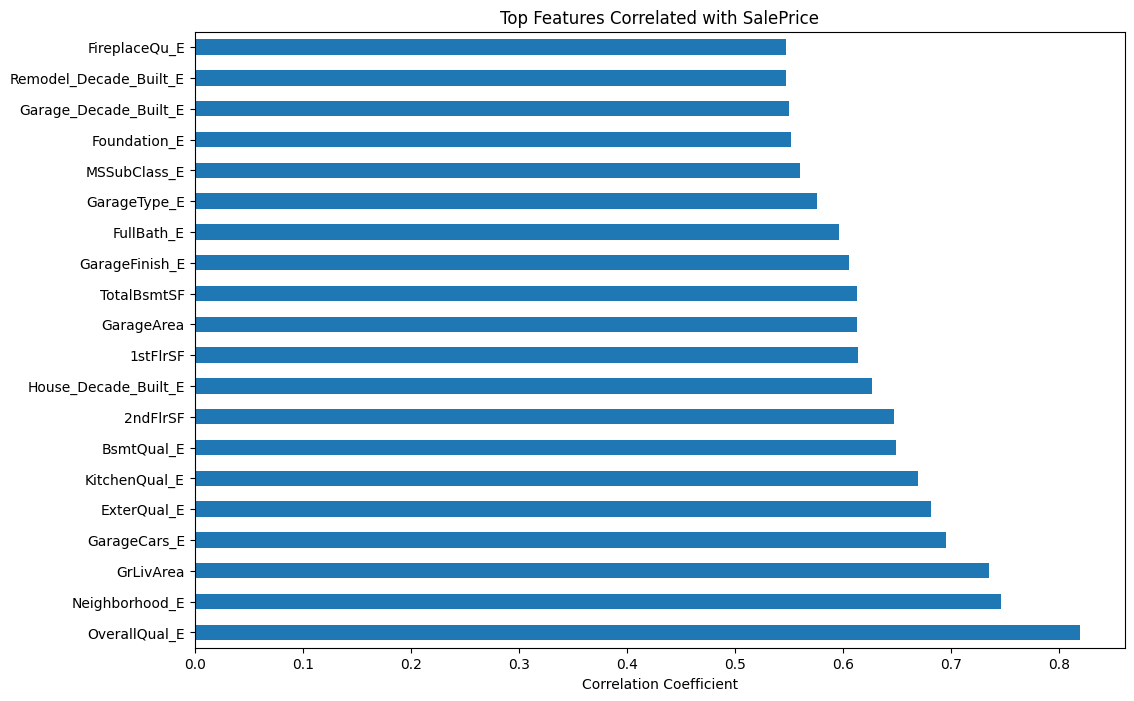

In [402]:
plt.figure(figsize=(12, 8))
saleprice_full_corr.drop('SalePrice').head(20).plot(kind='barh')
plt.title('Top Features Correlated with SalePrice')
plt.xlabel('Correlation Coefficient')
plt.show()

## 5.4. Feature Normalization (handle skewness)

Many regression models assume normally distributed data. Let's fix skewed features by applying log transform to the numerical features.

In [385]:
for col in quantitative:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])

train['SalePrice'] = np.log1p(train['SalePrice'])

LotFrontage
LotArea
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
House_Age
House_Age_Squared
Garage_Age
Garage_Age_Squared
Remodel_Age
Remodel_Age_Squared


## 5.5. Feature Scaling

Scaling numerical features improves distance-based calculations (for KNN, SVM classifiers) and prevents feature dominance.

In [387]:
def scale_multiple_features(train, test, columns):
    """Scale multiple numerical features """
    
    scaler = RobustScaler()
    
    # Fit on training data, transform both
    train[columns] = scaler.fit_transform(train[columns])
    test[columns] = scaler.transform(test[columns])
    
    return train, test

train, test = scale_multiple_features(train, test, quantitative)

# 5.6. Save the cleaned data

In [ ]:
train.to_csv('data/train_cleaned.csv', index=False)
test.to_csv('data/test_cleaned.csv', index=False)

# 6. Choose an Evaluation Metrics
For regression problems, common metrics include:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- R-squared

For classification problems, common metrics include:
- Accuracy
- Precision
- Recall
- F1-score
- AUC

The confusion matric and ROC Curve can also bring useful insights. 

# 7. Select Algorithms
- Start with simple regression algorithms like Linear Regression and gradually explore more complex models like Random Forest, Gradient Boosting, or XGBoost.
- Consider simple ensemble methods, such as simple average, weighted average, or voting ensembles, to combine multiple models for potentially better results.
- The model chosen depends on the data. A more complex model does not always constitute a better model.

# 8. Model Validation
- Split the data into training and validation sets. A common split is 70-30 or 80-20 for training and validation, respectively. This method is computationally less intensive and often used for initial model exploration or when dealing with very large datasets.
- K-Fold Cross Validation. This method provides a more reliable evaluation, especially with smaller datasets.
- Model validation is important to assess the model's generalization performance (i.e. assess how well the model performs on unseen data). This helps prevent overfitting and gives you a more reliable estimate of your model's performance.

# 9. Hyperparameter Tuning
- Tune the hyperparameters of your chosen algorithms on the validation dataset using techniques like grid search or random search to find the best combination.
- Optuna is an efficient and effective way to search for optimal hyperparameters.

# 10. Regularization
- Implement regularization techniques like L1 (Lasso) or L2 (Ridge) regularization to prevent overfitting.
- Many ML algorithms include regularization parameters, including L1 and L2, sometimes called reg_alpha or reg_lambda. Read up on your chosen algorithms regularization parameters and tune them accordingly on your validation set.

# 11. Train the final model

- Fit the best model using the optimal hyperparameters found on the whole training set (including the validation set)
- Model persistence : save the model weights for future use.

In [ ]:
def classification_model(model, X_train, X_test, y_train):
    """
    Train a classification model and assessing performance
    model: eg. model = LogisticRegression()
    X_train: train dataframe without the target column
    X_test: test dataframe    
    y_train: target column
    """
    
    # Use model class name as model name
    model_name = model.__class__.__name__
    print(f"Training: {model_name}")    
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Perform cross-validation with 5 folds
    scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = np.mean(scores)
    cv_std = np.std(scores)
    
    # Predictions on train set
    y_pred_train = model.predict(X_train)
    
    # Predict on test set 
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    accuracy = metrics.accuracy_score(y_train, y_pred_train)
    precision = metrics.precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
    recall = metrics.recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1 = metrics.f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    
    # Create results dictionary
    results_dict = {
        'Model_Name': model_name,
        'Train_Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'CV_Mean': cv_mean,
        'CV_Std': cv_std
    }
    
    return y_pred_test, y_pred_train, results_dict

# 12. Generate predictions on the test set

# 13. Save Model weights (model persistence)